In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:


DEPARTURE_S1_M1 = np.array([['16:30', '14:40', '03:55', '01:25', '10:26', '12:25', '06:35', '20:15'],      # S1 to M1:
                                  ['18:25', '06:20', '02:25', '05:15', '09:20', '15:15', '20:18', '22:20']])     # M1 to S1:

DEPARTURE_S2_M1 = np.array([['4:20', '08:35', '12:15', '18:12', '22:18'],
                                  ['12:25', '15:16', '18:21', '07:25', '21:20']])

DEPARTURE_M1_C1 = np.array([['05:50', '10:25', '12:30', '18:15', '21:05', '16:20'],
                                  ['04:00', '07:15', '10:55', '18:35', '21:25', '23:50']])

TOTAL_TIME_MATRIX = np.array([['18:35', '21:27', '19:46', '26:25', '28:36', '20:28', '32:16', '22:10'],
                               ['16:25', '19:38', '20:56', '09:13', '12:08'],
                               ['03:42', '02:56', '04:15', '03:18', '05:08', '03:50']])


<ipython-input-115-201b9d6b8f62>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  TOTAL_TIME_MATRIX = np.array([['18:35', '21:27', '19:46', '26:25', '28:36', '20:28', '32:16', '22:10'],


In [116]:
# Converting Time into Same unit(min.)
def convert_time_to_mins(time):
  hr, mins = [int(i) for i in time.split(':')]
  return (hr*60) + mins

def convert_mins_to_time(mins):
  mins = mins % (24*60)
  hr = mins//60
  min = mins % 60
  return f'{hr:02d}:{min:02d}'

def arrival_time(departure_time, tt):
  arrival_time = convert_time_to_mins(departure_time) + convert_time_to_mins(tt)
  return arrival_time

In [117]:
# Arrivals Times (arrival)
arrival_S1_M1 = [np.vectorize(arrival_time)(i, TOTAL_TIME_MATRIX[0]) for i in DEPARTURE_S1_M1]

arrival_S2_M1 = [np.vectorize(arrival_time)(i, TOTAL_TIME_MATRIX[1]) for i in DEPARTURE_S2_M1]

arrival_M1_C1 = [np.vectorize(arrival_time)(i, TOTAL_TIME_MATRIX[2]) for i in DEPARTURE_M1_C1]

In [118]:
df = pd.DataFrame({'Train Num': [],
                   'Departure Time (24 Hr)': [],
                   'Origin Node': [],
                   'Destination Node': [],
                   'Arrival Time (24 Hr)': [],
                   'Departure Time (Min)': [],
                   'Arrival Time (Min)': []})

## **ANS A: Creating DataFrames**

In [119]:
# From S1 to M1
for i in range(2):

  station1 = {0: ['S1', 'M1'],
                  1: ['M1', 'S1']}

  index = 0
  for dt, at in zip(DEPARTURE_S1_M1[i], arrival_S1_M1[i]):

    row1 = [f'Train {index + 1}', dt, station1[i][0], station1[i][1], at, dt, at]

    df.loc[len(df)] = row1

    index += 1

In [120]:
# From S2  to M1
for i in range(2):

  station2 = {0: ['S2', 'M1'],
                  1: ['M1', 'S2']}

  index = 0
  for dt, at in zip(DEPARTURE_S2_M1[i], arrival_S2_M1[i]):

    row2 = [f'Train {index + 1}', dt, station2[i][0], station2[i][1], at, dt, at]

    df.loc[len(df)] = row2

    index += 1

In [121]:
# From C1 to M1

for i in range(2):

  station3 = {0: ['C1', 'M1'],
                  1: ['M1', 'C1']}


  index = 0
  for dt, at in zip(DEPARTURE_M1_C1[i], arrival_M1_C1[i]):

    row3 = [f'Train {index + 1}', dt, station3[i][0], station3[i][1], at, dt, at]

    df.loc[len(df)] = row3

    index += 1

In [122]:
df['Arrival Time (24 Hr)'] = df['Arrival Time (24 Hr)'].apply(convert_mins_to_time)
df['Departure Time (Min)'] = df['Departure Time (Min)'].apply(convert_time_to_mins)

In [123]:
df.head()

,Train Num,Departure Time (24 Hr),Origin Node,Destination Node,Arrival Time (24 Hr),Departure Time (Min),Arrival Time (Min)
0,Train 1,16:30,S1,M1,11:05,990,2105
1,Train 2,14:40,S1,M1,12:07,880,2167
2,Train 3,03:55,S1,M1,23:41,235,1421
3,Train 4,01:25,S1,M1,03:50,85,1670
4,Train 5,10:26,S1,M1,15:02,626,2342


## **ANS B: Scheduling Intersection**

### **Layover Time:**

In [124]:
# layover time: S1 to M1 to C1

a1 = df[df['Origin Node'] == 'S1']
a2 = df[(df['Origin Node'] == 'M1') & (df['Destination Node'] == 'C1')]

layover_time_S1_M1 = {}

for ti_S1_M1 in range(len(a1)):

  at_min_ti = convert_time_to_mins(a1.iloc[ti_S1_M1]['Arrival Time (24 Hr)'])
  # layover time for train i at M1 wrt each train going M1 to C1
  layover_ti = [t - at_min_ti if t > at_min_ti else 1440 - at_min_ti + t for t in a2['Departure Time (Min)']]

  train_name = a1.iloc[ti_S1_M1]['Train Num']
  layover_time_S1_M1[train_name] = layover_ti

layover_time_S1_M1_df = pd.DataFrame(layover_time_S1_M1, index = a2['Train Num'].values).T

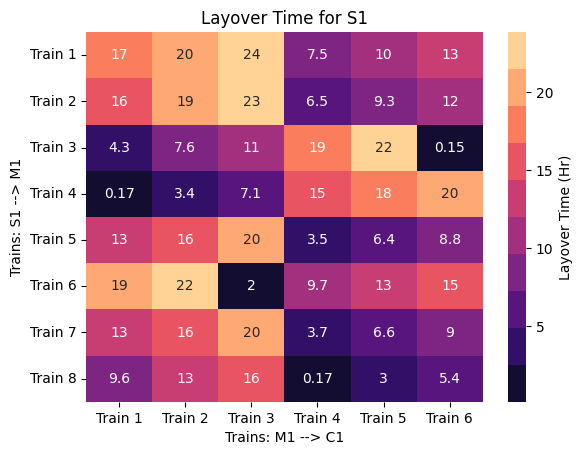

In [125]:
sns.heatmap(layover_time_S1_M1_df/60, cmap = sns.color_palette("magma", 10), annot=True, cbar_kws={'label': 'Layover Time (Hr)'})

plt.xlabel('Trains: M1 --> C1')
plt.ylabel('Trains: S1 --> M1')
plt.title('Layover Time for S1')

plt.savefig('./B1_layover_S1.png', dpi = 300, bbox_inches='tight')

plt.show()

In [126]:
# layover time: S2 to M1 to C1

b1 = df[df['Origin Node'] == 'S2']
b2 = df[(df['Origin Node'] == 'M1') & (df['Destination Node'] == 'C1')]

layover_times_S2_M1 = {}

for ti_S2_M1 in range(len(b1)):


  at_min_ti = convert_time_to_mins(b1.iloc[ti_S2_M1]['Arrival Time (24 Hr)'])
  # layover time for train i at M1 wrt each train going M1 to C1
  layover_ti = [t - at_min_ti if t > at_min_ti else 1440 - at_min_ti + t for t in b2['Departure Time (Min)']]

  train_name = b1.iloc[ti_S2_M1]['Train Num']
  layover_times_S2_M1[train_name] = layover_ti

layover_times_S2_M1_df = pd.DataFrame(layover_times_S2_M1, index = b2['Train Num'].values).T

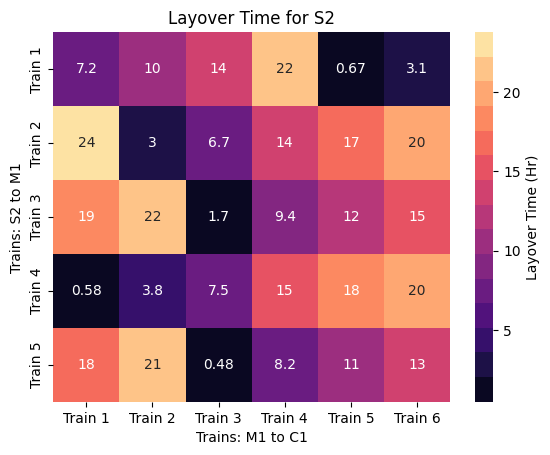

In [127]:
sns.heatmap(layover_times_S2_M1_df/60, cmap = sns.color_palette("magma", 15), annot=True, cbar_kws={'label': 'Layover Time (Hr)'})

plt.xlabel('Trains: M1 to C1')
plt.ylabel('Trains: S2 to M1')
plt.title('Layover Time for S2')

plt.savefig('./B1_layover_S2.png', dpi = 300, bbox_inches='tight')

plt.show()

### **Waiting Time:**

In [128]:
# waiting time: S1 to M1 to C1
c1 = df[df['Origin Node'] == 'S1']
c2 = df[df['Origin Node'] == 'S2']

waiting_times = {}

for ti_S1 in range(len(c1)):

  at_min_ti_S1 = convert_time_to_mins(c1.iloc[ti_S1]['Arrival Time (24 Hr)'])

  at_min_ti_S2 = np.vectorize(convert_time_to_mins)(c2['Arrival Time (24 Hr)'])

  waiting_time_ti_S1 = at_min_ti_S2 - at_min_ti_S1

  train_name = c1.iloc[ti_S1]['Train Num']
  waiting_times[train_name] = waiting_time_ti_S1

waiting_times_df = pd.DataFrame(waiting_times, index = c2['Train Num'].values).T

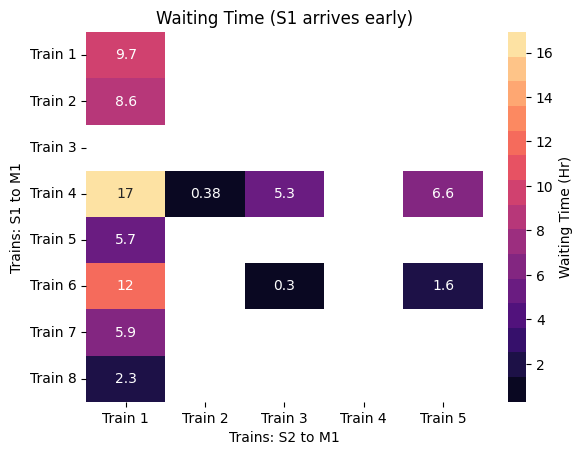

In [129]:
#  Heatmap of waiting times for S1

waiting_times_S1 = waiting_times_df[waiting_times_df > 0]

sns.heatmap(waiting_times_S1/60, cmap = sns.color_palette("magma", 15), annot=True, cbar_kws={'label': 'Waiting Time (Hr)'})

plt.xlabel('Trains: S2 to M1')
plt.ylabel('Trains: S1 to M1')
plt.title('Waiting Time (S1 arrives early)')

plt.savefig('./B2_wait_S1.png', dpi = 300, bbox_inches='tight')

plt.show()

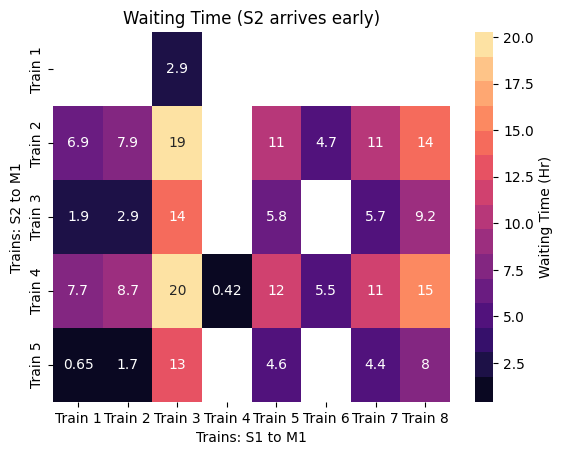

In [130]:
#  Heatmap of waiting times for S2

waiting_times_S2 = waiting_times_df[waiting_times_df <= 0]

sns.heatmap(abs(waiting_times_S2/60).T, cmap = sns.color_palette("magma", 15), annot=True, cbar_kws={'label': 'Waiting Time (Hr)'})

plt.xlabel('Trains: S1 to M1')
plt.ylabel('Trains: S2 to M1')
plt.title('Waiting Time (S2 arrives early)')

plt.savefig('./B2_wait_S2.png', dpi = 300, bbox_inches='tight')

plt.show()

## **ANS C: Parting Ways**

In [131]:
# trains going from C1 to M1
t1 = df[df['Origin Node'] == 'C1']

# trains going from M1 to S1
t_M1_S1 = df[(df['Origin Node'] == 'M1') & (df['Destination Node'] == 'S1')]

# trains going from M1 to S2
t_M1_S2 = df[(df['Origin Node'] == 'M1') & (df['Destination Node'] == 'S2')]

dt_S1 = t_M1_S1['Departure Time (Min)']
dt_S2 = t_M1_S2['Departure Time (Min)']

layover_S1 = np.zeros((len(t1), len(dt_S1)))
layover_S2 = np.zeros((len(t1), len(dt_S2)))

wait_S1 = np.zeros((len(t1), len(dt_S1)))
wait_S2 = np.zeros((len(t1), len(dt_S2)))

In [132]:
for ti_M1 in range(len(t1)):

  train_name = t1.iloc[ti_M1]['Train Num']
  at_min_ti_M1 = convert_time_to_mins(t1.iloc[ti_M1]['Arrival Time (24 Hr)'])

  dt_at_diff_S1 =  [t - at_min_ti_M1 if t > at_min_ti_M1 else 1440 - at_min_ti_M1 + t for t in dt_S1]
  min_id_diff_S1 = np.argmin(dt_at_diff_S1)

  dt_at_diff_S2 =  [t - at_min_ti_M1 if t > at_min_ti_M1 else 1440 - at_min_ti_M1 + t for t in dt_S2]
  min_id_diff_S2 = np.argmin(dt_at_diff_S2)

  # S1 leaves early
  if dt_at_diff_S1[min_id_diff_S1] <= dt_at_diff_S2[min_id_diff_S2]:

    layover_S1[ti_M1, min_id_diff_S1] = dt_at_diff_S1[min_id_diff_S1]

    # S2 will wait
    dt_min_S1 = dt_S1.iloc[min_id_diff_S1]
    wait_S2[ti_M1, :] = [t - dt_min_S1 if t > dt_min_S1 else 1440 - dt_min_S1 + t for t in dt_S2]


  # S2 leaves early
  else:

    layover_S2[ti_M1, min_id_diff_S2] = dt_at_diff_S2[min_id_diff_S2]

    # S1 will wait
    dt_min_S2 = dt_S2.iloc[min_id_diff_S2]
    wait_S1[ti_M1, :] = [t - dt_min_S2 if t > dt_min_S2 else 1440 - dt_min_S2 + t for t in dt_S1]


In [133]:
layover_S1_df = pd.DataFrame(layover_S1, columns = t_M1_S1['Train Num'].values, index = t1['Train Num'].values)
layover_S2_df = pd.DataFrame(layover_S2, columns = t_M1_S2['Train Num'].values, index = t1['Train Num'].values)

wait_S1_df = pd.DataFrame(wait_S1, columns = t_M1_S1['Train Num'].values, index = t1['Train Num'].values)
wait_S2_df = pd.DataFrame(wait_S2, columns = t_M1_S2['Train Num'].values, index = t1['Train Num'].values)

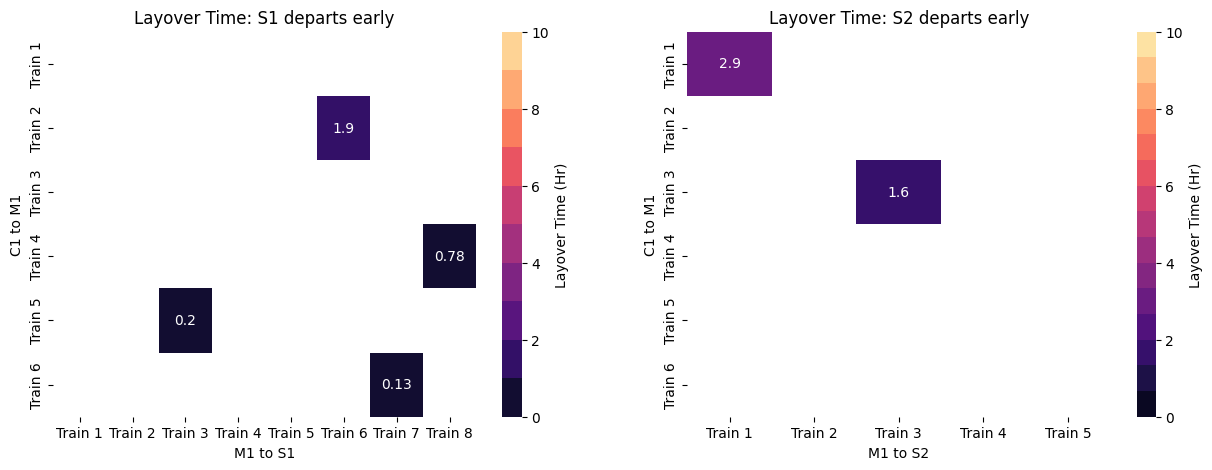

In [134]:
# Plotting - Layover time
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# When S1 departs before
layover_S1 = layover_S1_df[layover_S1_df != 0]
sns.heatmap(layover_S1/60, cmap = sns.color_palette("magma", 10), annot=True, vmin = 0, vmax = 10, ax = axs[0], cbar_kws={'label': 'Layover Time (Hr)'})

axs[0].set_title('Layover Time: S1 departs early')
axs[0].set_ylabel('C1 to M1')
axs[0].set_xlabel('M1 to S1')

# When S1 departs before
layover_S2 = layover_S2_df[layover_S2_df != 0]
sns.heatmap(layover_S2/60, cmap = sns.color_palette("magma", 15), annot=True, vmin = 0, vmax = 10, ax = axs[1], cbar_kws={'label': 'Layover Time (Hr)'})

axs[1].set_title('Layover Time: S2 departs early')
axs[1].set_ylabel('C1 to M1')
axs[1].set_xlabel('M1 to S2')

plt.savefig('./C_layover.png', dpi = 300, bbox_inches='tight')

plt.show()

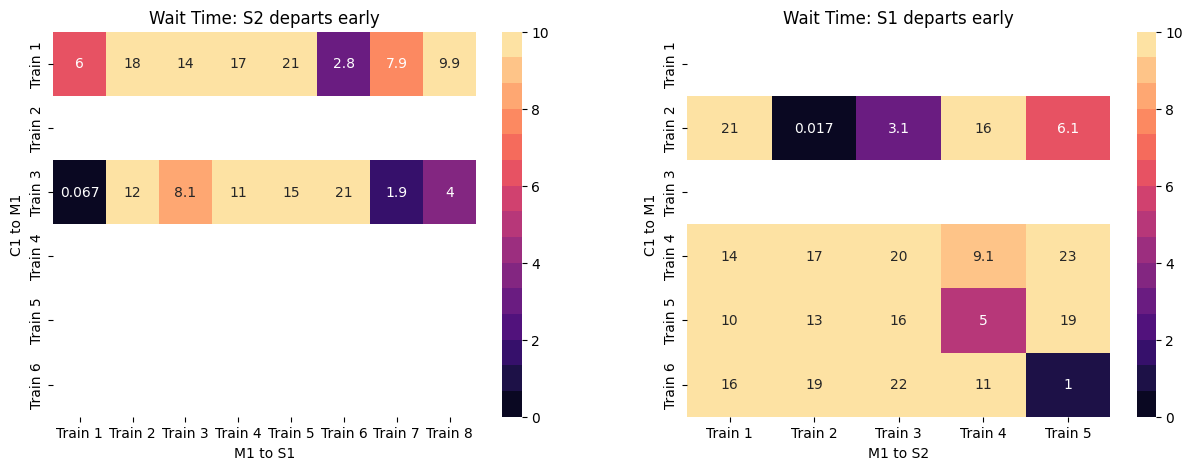

In [135]:
# Plotting - Waiting time
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# When S1 departs before
wait_S1 = wait_S1_df[wait_S1_df != 0]
sns.heatmap(wait_S1/60, cmap = sns.color_palette("magma", 15), annot=True, vmin = 0, vmax = 10, ax = axs[0])

axs[0].set_title('Wait Time: S2 departs early')
axs[0].set_ylabel('C1 to M1')
axs[0].set_xlabel('M1 to S1')

# When S1 departs before
wait_S2 = wait_S2_df[wait_S2_df != 0]
sns.heatmap(wait_S2/60, cmap = sns.color_palette("magma", 15), annot=True, vmin = 0, vmax = 10, ax = axs[1])

axs[1].set_title('Wait Time: S1 departs early')
axs[1].set_ylabel('C1 to M1')
axs[1].set_xlabel('M1 to S2')

plt.savefig('./C_wait.png', dpi = 300, bbox_inches='tight')

plt.show()

### **ANS D: Introducing Direct Trains from Source to Cities to City of Attractions**

In [136]:


# Departures time
departure_time_S1_C1 = np.array([['05:30', '20:15'],
                                ['08:15', '02:00']])

departure_time_S2_C1 = np.array([['15:45', '07:30'],
                                ['15:00', '09:00']])


# Arrivals time
arrival_time_S1_C1 = np.array([['29:15', '46:15'],
                              ['32:00', '28:00']])

arrival_time_S2_C1 = np.array([['32:45', '24:45'],
                              ['33:45', '26:15']])

S1C1_reach_M1 = np.array([['25:30', '42:15'],
                          ['12:00', '06:00']])

S2C1_reach_M1 = np.array([['29:45', '22:45'],
                          ['18:00', '11:45']])

In [137]:
# create new dataframe to include direct trains
df_direct_train = pd.DataFrame({'Train Num': [],
                   'Departure Time (24 Hr)': [],
                   'Origin Node': [],
                   'Destination Node': [],
                   'Arrival Time (24 Hr)': [],
                   'Departure Time (Min)': [],
                   'Arrival Time (Min)': []})

In [138]:
# S1 - C1

for i in range(2):

  station_info = {0: ['S1', 'C1'],
                  1: ['C1', 'S1']}

  index = 0
  for dt, at in zip(departure_time_S1_C1[i], arrival_time_S1_C1[i]):

    new_row = [f'Train {index + 1}', dt, station_info[i][0], station_info[i][1], at, dt, at]

    df_direct_train.loc[len(df_direct_train)] = new_row

    index += 1

In [139]:
# S2 - C1

for i in range(2):

  station_info = {0: ['S2', 'C1'],
                  1: ['C1', 'S2']}

  index = 0
  for dt, at in zip(departure_time_S2_C1[i], arrival_time_S2_C1[i]):

    new_row = [f'Train {index + 1}', dt, station_info[i][0], station_info[i][1], at, dt, at]

    df_direct_train.loc[len(df_direct_train)] = new_row

    index += 1

In [140]:
# Modifing Arrival-Departure

df1 = pd.concat([df, df_direct_train], ignore_index=True, sort=False)
df1

,Train Num,Departure Time (24 Hr),Origin Node,Destination Node,Arrival Time (24 Hr),Departure Time (Min),Arrival Time (Min)
0,Train 1,16:30,S1,M1,11:05,990,2105
1,Train 2,14:40,S1,M1,12:07,880,2167
2,Train 3,03:55,S1,M1,23:41,235,1421
3,Train 4,01:25,S1,M1,03:50,85,1670
4,Train 5,10:26,S1,M1,15:02,626,2342
5,Train 6,12:25,S1,M1,08:53,745,1973
6,Train 7,06:35,S1,M1,14:51,395,2331
7,Train 8,20:15,S1,M1,18:25,1215,2545
8,Train 1,18:25,M1,S1,13:00,1105,2220
9,Train 2,06:20,M1,S1,03:47,380,1667


## **ANS E: Train Hopping**

In [141]:
# 1. passenger from S1 plans to hop into direct train from S2−→C1

t1 = df1[(df1['Origin Node'] == 'S1') & (df1['Destination Node'] == 'M1')]
t2 = df1[(df1['Origin Node'] == 'S2') & (df1['Destination Node'] == 'C1')]

wait_times = {}

for S1_M1_ti in range(len(t1)):
    train_name = t1.iloc[S1_M1_ti]['Train Num']

    at_min_S1_M1_ti = convert_time_to_mins(t1.iloc[S1_M1_ti]['Arrival Time (24 Hr)'])

    S2C1_reach_M1_min = [convert_time_to_mins(i) for i in S2C1_reach_M1[0]]

    ht_ti = [t - at_min_S1_M1_ti if t > at_min_S1_M1_ti else 1440 - at_min_S1_M1_ti + t for t in S2C1_reach_M1_min]

    wait_times[train_name] = ht_ti


hop_wait_times_df = pd.DataFrame(wait_times, index = t2['Train Num'].values)

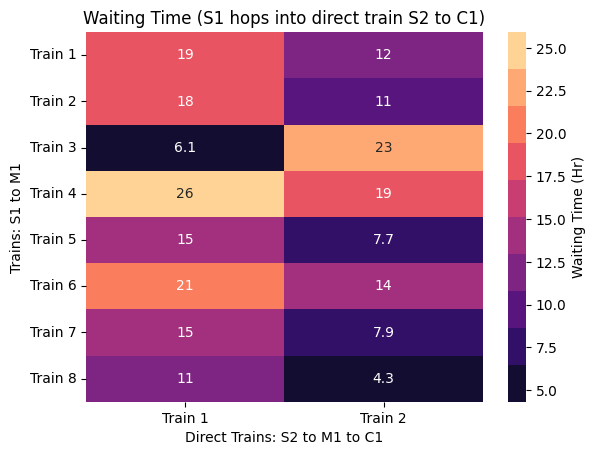

In [142]:
# S1 hops in direct train: S2 to C1

sns.heatmap((hop_wait_times_df/60).T, cmap = sns.color_palette("magma", 10), annot=True, cbar_kws={'label': 'Waiting Time (Hr)'})

plt.xlabel('Direct Trains: S2 to M1 to C1')
plt.ylabel('Trains: S1 to M1')
plt.title('Waiting Time (S1 hops into direct train S2 to C1)')

plt.savefig('./E1_hopping.png', dpi = 300, bbox_inches='tight')

plt.show()

In [143]:
# 2. passenger from S2 plans to hop out from direct train from C1−→S1

t1 = df1[(df1['Origin Node'] == 'M1') & (df1['Destination Node'] == 'S2')]
t2 = df1[(df1['Origin Node'] == 'C1') & (df1['Destination Node'] == 'S1')]

wait_times = {}

for M1_S2_ti in range(len(t1)):
    train_name = t1.iloc[M1_S2_ti]['Train Num']

    dt_min_M1_S2_ti = t1.iloc[M1_S2_ti]['Departure Time (Min)']

    S1C1_reach_M1_min = [convert_time_to_mins(i) for i in S1C1_reach_M1[1]]

    ht_ti = [dt_min_M1_S2_ti - t if dt_min_M1_S2_ti > t else 1440 + dt_min_M1_S2_ti - t for t in S1C1_reach_M1_min]
    wait_times[train_name] = ht_ti

hop_wait_times_df = pd.DataFrame(wait_times, index = t2['Train Num'].values)

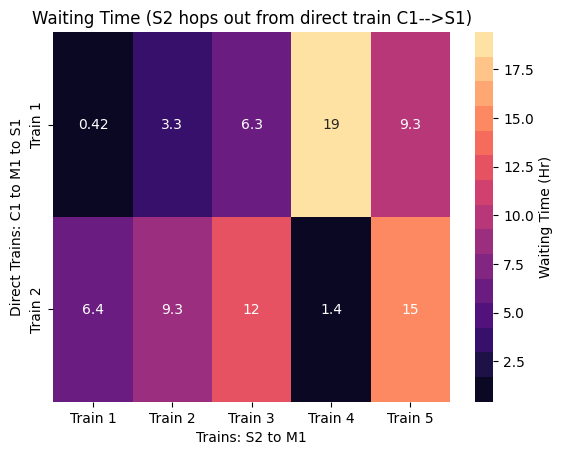

In [144]:
# S2 hops out of direct train: C1 --> S1

sns.heatmap((hop_wait_times_df/60), cmap = sns.color_palette("magma", 15), annot=True, cbar_kws={'label': 'Waiting Time (Hr)'})

plt.xlabel('Trains: S2 to M1')
plt.ylabel('Direct Trains: C1 to M1 to S1')
plt.title('Waiting Time (S2 hops out from direct train C1-->S1)')

plt.savefig('./E2_hopping.png', dpi = 300, bbox_inches='tight')

plt.show()